In [2]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import tomotopy as tp
import re
import jieba
from tqdm.notebook import tqdm
import jieba.posseg as pseg
from gensim import corpora, models

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
#文档
data=pd.read_csv(r'data/哈啰单车.csv')
data.head()

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id
0,4345017256139766,HiT6tpLeu,3515479467,我觉得我应该改个名Erin,开春了，放车了#哈啰单车#,NaN,沈阳·IKEA宜家家居(沈阳商场),NaN,哈啰单车,0,1,1,2019-03-01 12:58,小米Note 3 拍人更美,['https://wx4.sinaimg.cn/large/d189f5ably1g0n7...,NaN,NaN
1,4360270770077965,HphUV0khv,3480351355,JoYu-9,中午蹬起#哈啰单车#和小帆帆见面约饭，还是常去的，聊了很多，突然又有了学习和进步的动力，回想...,NaN,北京·二贵酸汤鱼土家菜(中关村店),NaN,哈啰单车,0,0,1,2019-04-12 15:10,iPhone客户端,['https://wx2.sinaimg.cn/large/cf71f27bly1g1zv...,NaN,NaN
2,4359981191009021,HpanR4eux,7045832483,张张Seoul,#哈啰单车#真的是最好骑的共享单车，没有之一。到现在为止都没有遇到坏的，唯一的缺点就是为什么...,NaN,NaN,NaN,哈啰单车,0,0,0,2019-04-11 19:59,OPPO A7x,NaN,NaN,NaN
3,4358856073183460,HoH79dma8,6476628742,三言财经,#哈啰单车1元骑行15分钟#【#哈啰单车#调整北京地区计费规则：每15分钟1元】三言财经4月...,NaN,NaN,哈啰单车,"哈啰单车1元骑行15分钟,哈啰单车",0,0,0,2019-04-08 17:28,微博 weibo.com,['https://wx4.sinaimg.cn/large/0074jgZUgy1g1vc...,NaN,NaN
4,4358445622424184,Howr8aaDK,5139540825,redhairpin,#哈啰单车#这破公司可能是想钱想疯了从25.9到35.9到59.9到……从一天4次一小时到一...,NaN,NaN,NaN,哈啰单车,0,1,2,2019-04-07 14:17,小米6 拍人更美,['https://wx4.sinaimg.cn/large/005BOZlLly1g1u1...,NaN,NaN


In [4]:
data.isnull().sum()

id               0
bid              0
user_id          0
用户昵称             0
微博正文             0
头条文章url       1290
发布位置           972
艾特用户           971
话题               8
转发数              0
评论数              0
点赞数              0
发布时间             0
发布工具            17
微博图片url        554
微博视频url       1252
retweet_id    1259
dtype: int64

In [5]:
# 只保留中文
data['微博正文']=data['微博正文'].astype('str')
data['content'] = data['微博正文'].str.replace("[^\u4e00-\u9fa5]", "")

In [6]:
# 移除常用词以及分词
stoplist = [i.strip() for i in open(r'data/stopword.txt',encoding='utf-8').readlines()]
def segment(text):
    words = jieba.cut(text)
    words = [w for w in words if w not in stoplist if len(w)>1]
    return words

data['words'] = data['content'].apply(segment)
print("二次删除停用词和分词成功！！！")
data.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/stopword.txt'

In [7]:
# 移除常用词以及分词
stoplist = [i.strip() for i in open(r'data/stopwords.txt',encoding='utf-8').readlines()]
def segment(text):
    words = jieba.cut(text)
    words = [w for w in words if w not in stoplist if len(w)>1]
    return words

data['words'] = data['content'].apply(segment)
print("二次删除停用词和分词成功！！！")
data.head(1)

Building prefix dict from the default dictionary ...
2022-06-15 15:25:28,896 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13391\AppData\Local\Temp\jieba.cache
2022-06-15 15:25:28,898 : DEBUG : Loading model from cache C:\Users\13391\AppData\Local\Temp\jieba.cache
Loading model cost 0.433 seconds.
2022-06-15 15:25:29,331 : DEBUG : Loading model cost 0.433 seconds.
Prefix dict has been built successfully.
2022-06-15 15:25:29,332 : DEBUG : Prefix dict has been built successfully.


删除停用词和分词成功！！！


,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id,content,words
0,4345017256139766,HiT6tpLeu,3515479467,我觉得我应该改个名Erin,开春了，放车了#哈啰单车#,NaN,沈阳·IKEA宜家家居(沈阳商场),NaN,哈啰单车,0,1,1,2019-03-01 12:58,小米Note 3 拍人更美,['https://wx4.sinaimg.cn/large/d189f5ably1g0n7...,NaN,NaN,开春了放车了哈啰单车,"[开春, 放车, 哈啰, 单车]"


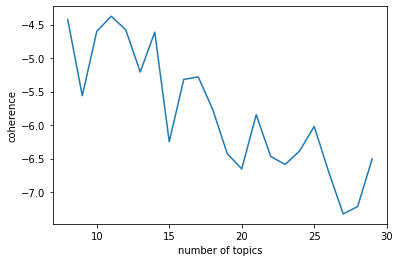

In [8]:
#查询主题个数比较合适
def find_k(docs, min_k, max_k, min_df):
    #min_df 词语最少出现在2个文档中
    import matplotlib.pyplot as plt
    scores = []
    for k in range(min_k, max_k):
        #seed随机种子，保证运行的结果一样
        mdl = tp.LDAModel(min_df=min_df, k=k,seed=555)
        for words in docs:
            if words:
                mdl.add_doc(words)
        mdl.train(20)
        coh = tp.coherence.Coherence(mdl)
        scores.append(coh.get_score())

    #x = list(range(min_k, max_k - 1))  # 区间最右侧的值。注意：不能大于max_k
    #print(x)
    #print()
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()    
    
find_k(docs=data['words'], min_k=8, max_k=30, min_df=2)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# 将文本中的词语转换为词频矩阵
cleanchap = [" ".join(w) for w in data['words']]

Tfidfvectorizer =TfidfVectorizer(max_df=0.4, 
                             min_df=2, 
                             max_features=2000,stop_words=stoplist) #创建词袋数据结构
data_vectorized = Tfidfvectorizer.fit_transform(cleanchap)

In [10]:
pd.DataFrame(data_vectorized.toarray(),columns=Tfidfvectorizer.get_feature_names()).to_csv('data/哈啰单车_Tf-idf.csv',encoding='utf_8_sig')

In [11]:
# 设定LDA模型
from sklearn.decomposition import LatentDirichletAllocation
n_topics=14
ldamodel = LatentDirichletAllocation(n_components = n_topics)
ldamodel.fit(data_vectorized)

LatentDirichletAllocation(n_components=14)

In [12]:
# 主题词打印函数
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
n_top_words = 12
tf_feature_names = Tfidfvectorizer.get_feature_names()
print_top_words(ldamodel, tf_feature_names, n_top_words)

Topic #0:
出行 素质 这辆 自动 停车 地方 客服 气死 迟到 生气 骑车 扫码
Topic #1:
停车 客服 出行 调度 骑车 服务区 半小时 两次 支付 区域 公司 系统
Topic #2:
停车 不让 看不到 真想 找到 真的 定位 單車 小蓝 出行 屁股 不准
Topic #3:
出行 迟到 微博 视频 上海 沈阳 共享 真的 客服 分钟 上市 绿色
Topic #4:
拼团 出行 有人 极致 有没有 哈罗 打卡 迟到 第一次 辣鸡 受死 关锁
Topic #5:
共享 助力车 垃圾 出行 再也 美团 停车 奶茶 不骑 定位 骑车 长沙
Topic #6:
出行 不行 共享 客服 青桔 企业 气死我了 调整 早上 公里 扫不开 运营
Topic #7:
崩溃 打不开 啊啊啊 一个月 停车 定位 出行 下班 共享 粉色 文明 骑行
Topic #8:
故障 共享 小蓝车 真的 助力车 无语 电动车 理解 青桔 自行车 赔偿 出行
Topic #9:
差点 手机 早上 涨价 哈尔滨 迟到 出行 哈哈哈 用户 小蓝 解锁 免费
Topic #10:
共享 车子 订单 上班 客服 出行 调度 开锁 停车 恶意 明明 破坏
Topic #11:
网络 骑行 开小差 免费 出行 美团 黄车 保养 走路 半天 回仓 共享
Topic #12:
出行 哈罗 支付宝 客服 共享 骑行 网友 小时 南京 广州 情况 开锁
Topic #13:
出行 骑行 网页 链接 谢谢 操作 服务器 手机 快乐 太阳 上锁 视频



In [13]:
import joblib
joblib.dump(ldamodel, r'data/哈啰model_1.pkl')

['data/哈啰model_1.pkl']

In [14]:
import numpy as np

# 构建文档-词频矩阵
lda_output = ldamodel.transform(data_vectorized)
# 列名
topicnames = ["Topic" + str(i) 
              for i in range(ldamodel.n_components)]
# 行索引名
#docnames = ["Doc" + str(i) for i in range(len(data.words))]

# 转化为pd.DataFrame
df_document_topic = pd.DataFrame(np.round(lda_output, 4), 
                                 columns=topicnames, 
                                 index=data['bid'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [15]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,dominant_topic
bid,,,,,,,,,,,,,,,
HiT6tpLeu,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0.0714,0
HphUV0khv,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.0214,0.7215,0.0214,12
HpanR4eux,0.0227,0.0227,0.0227,0.0227,0.0227,0.7054,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,5
HoH79dma8,0.0092,0.3435,0.0092,0.0092,0.0092,0.0092,0.4152,0.0092,0.0092,0.1401,0.0092,0.0092,0.0092,0.0092,6
Howr8aaDK,0.0209,0.7287,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,0.0209,1


In [16]:
result_data=pd.merge(data,df_document_topic,on='bid')

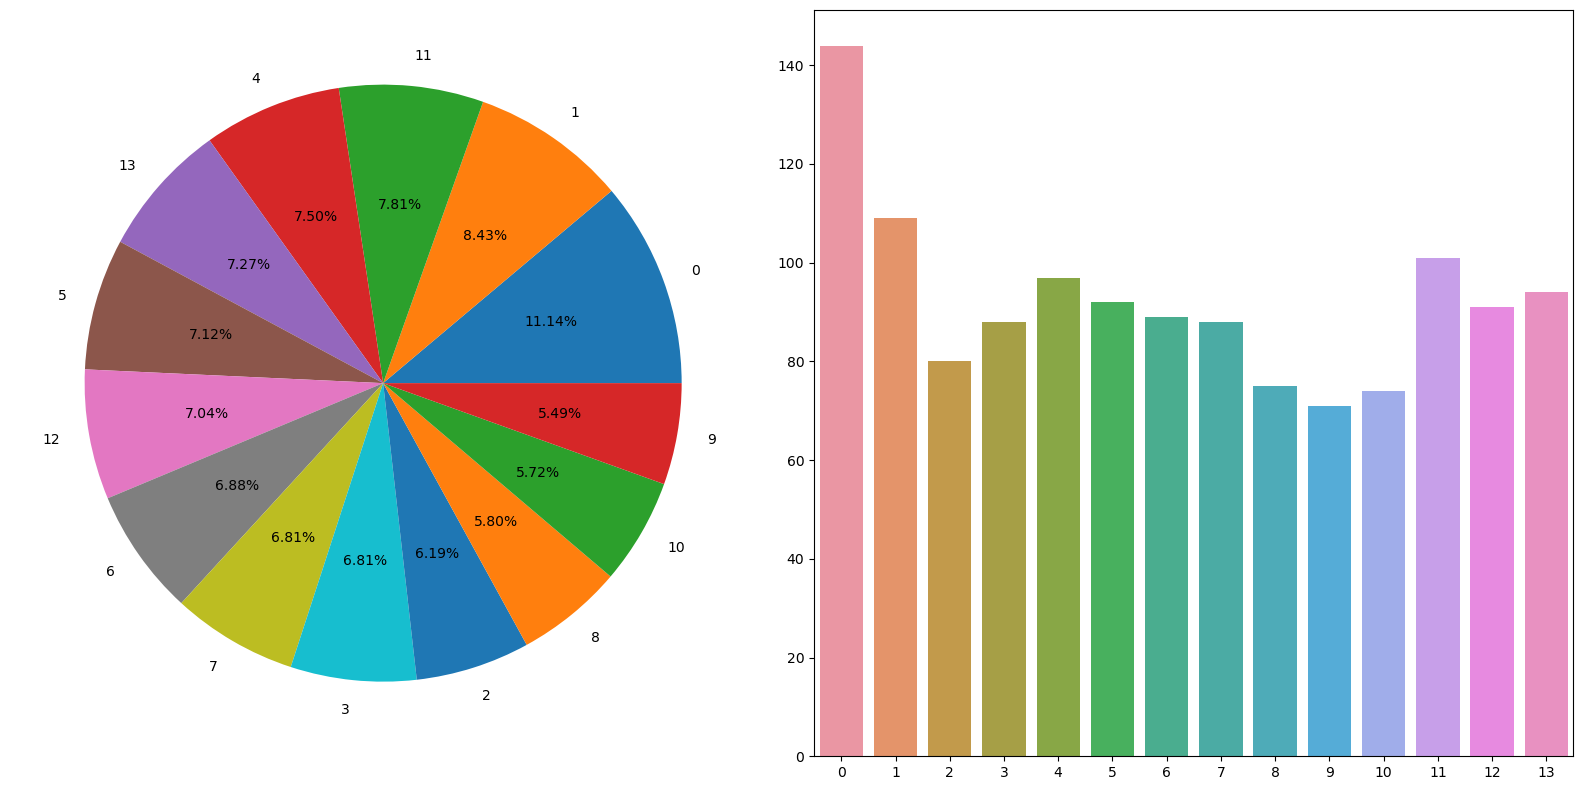

In [17]:
# 主题分布图
import seaborn as sns 
result_type_counts = result_data['dominant_topic'].value_counts()
fig,axes = plt.subplots(1,2,figsize=(16,8),dpi=100)
axes[0].pie(result_type_counts.values,autopct="%.2f%%",labels=result_type_counts.index)
sns.barplot(result_type_counts.index,result_type_counts.values)
plt.savefig(r'data/哈啰单车_主题分布图.png')
plt.tight_layout()

In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,144
1,1,109
2,11,101
3,4,97
4,13,94
5,5,92
6,12,91
7,6,89
8,7,88
9,3,88


In [19]:
result_data.to_csv('data/哈啰单车_data.csv',encoding='utf_8_sig')